# Entrenamiento de Modelos de Machine Learning para API de Pingüinos

Este notebook entrena modelos de ML y los guarda en la carpeta compartida `./models` para que la API FastAPI los consuma automáticamente.

## 1. Importar librerías necesarias

In [1]:
import os
import json
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Definir configuración y rutas

In [2]:
# Configuración
MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(exist_ok=True)

# Features esperadas para los pingüinos
PENGUIN_FEATURES = [
    "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"
]

print(f"📁 Directorio de modelos: {MODELS_DIR.absolute()}")
print(f"📊 Features a usar: {PENGUIN_FEATURES}")

📁 Directorio de modelos: /app/models
📊 Features a usar: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


## 3. Cargar y explorar el dataset de pingüinos

In [3]:
# Cargar dataset de pingüinos de seaborn
df = sns.load_dataset("penguins")
print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()

Dataset original: 344 filas, 7 columnas

Primeras filas:


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
# Información del dataset
print("Información del dataset:")
df.info()
print(f"\nValores faltantes por columna:")
print(df.isnull().sum())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB

Valores faltantes por columna:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


In [5]:
# Limpiar datos: eliminar filas con valores faltantes en features importantes
df_clean = df.dropna(subset=PENGUIN_FEATURES + ["species"])
print(f"Dataset limpio: {df_clean.shape[0]} filas")

# Distribución de especies
print("\nDistribución de especies:")
print(df_clean['species'].value_counts())

Dataset limpio: 342 filas

Distribución de especies:
species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64


## 4. Visualizar los datos

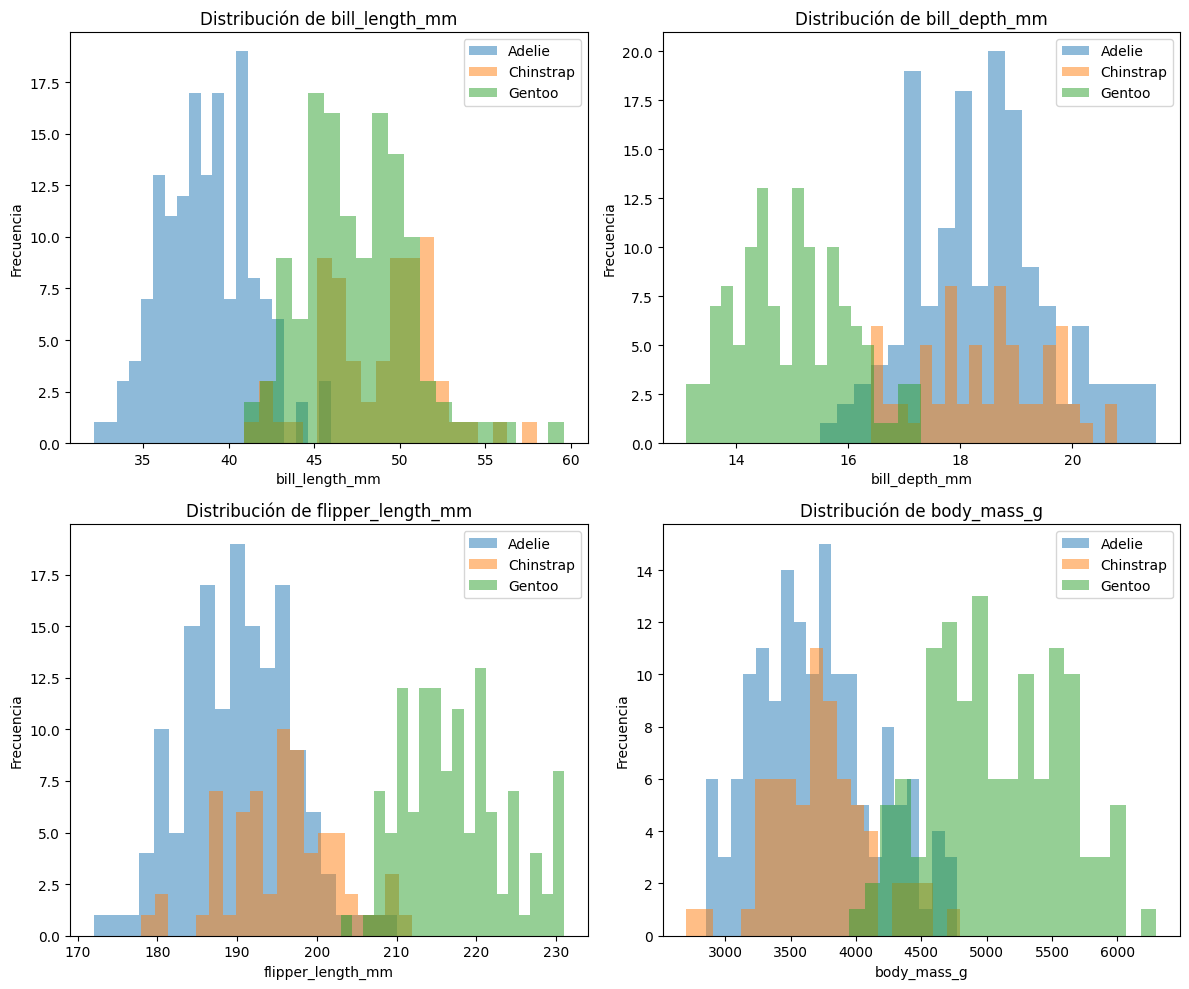

In [6]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, feature in enumerate(PENGUIN_FEATURES):
    for species in df_clean['species'].unique():
        subset = df_clean[df_clean['species'] == species]
        axes[idx].hist(subset[feature], alpha=0.5, label=species, bins=20)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].legend()
    axes[idx].set_title(f'Distribución de {feature}')

plt.tight_layout()
plt.show()

## 5. Preparar datos para entrenamiento

In [7]:
# Preparar X (features) e y (target)
X = df_clean[PENGUIN_FEATURES].astype(float)
y = df_clean["species"].astype("category").cat.codes

# Guardar mapeo de clases
classes = list(df_clean["species"].astype("category").cat.categories)
class_mapping = {i: name for i, name in enumerate(classes)}

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nMapeo de clases:")
for idx, name in class_mapping.items():
    print(f"  {idx}: {name}")

X shape: (342, 4)
y shape: (342,)

Mapeo de clases:
  0: Adelie
  1: Chinstrap
  2: Gentoo


In [8]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

Conjunto de entrenamiento: 273 muestras
Conjunto de prueba: 69 muestras


## 6. Entrenar modelo KNN

In [9]:
# Pipeline KNN con escalado
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

# Entrenar
knn_pipeline.fit(X_train, y_train)

# Predecir
y_pred_knn = knn_pipeline.predict(X_test)

# Métricas
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average="macro")

print("🎯 Modelo KNN entrenado:")
print(f"  - Accuracy: {knn_accuracy:.4f}")
print(f"  - F1-score (macro): {knn_f1:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_knn, target_names=classes))

🎯 Modelo KNN entrenado:
  - Accuracy: 1.0000
  - F1-score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



## 7. Entrenar modelo Random Forest

In [10]:
# Pipeline Random Forest (no necesita escalado)
rf_pipeline = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Entrenar
rf_pipeline.fit(X_train, y_train)

# Predecir
y_pred_rf = rf_pipeline.predict(X_test)

# Métricas
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average="macro")

print("🌲 Modelo Random Forest entrenado:")
print(f"  - Accuracy: {rf_accuracy:.4f}")
print(f"  - F1-score (macro): {rf_f1:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=classes))

🌲 Modelo Random Forest entrenado:
  - Accuracy: 1.0000
  - F1-score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



## 8. Entrenar modelo SVM (adicional)

In [11]:
# Pipeline SVM con escalado
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel='rbf', probability=True, random_state=42))
])

# Entrenar
svm_pipeline.fit(X_train, y_train)

# Predecir
y_pred_svm = svm_pipeline.predict(X_test)

# Métricas
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average="macro")

print("🔮 Modelo SVM entrenado:")
print(f"  - Accuracy: {svm_accuracy:.4f}")
print(f"  - F1-score (macro): {svm_f1:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_svm, target_names=classes))

🔮 Modelo SVM entrenado:
  - Accuracy: 1.0000
  - F1-score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



## 9. Guardar modelos en la carpeta compartida

In [12]:
# Guardar modelos como archivos .pkl
joblib.dump(knn_pipeline, MODELS_DIR / "knn.pkl")
joblib.dump(rf_pipeline, MODELS_DIR / "rf.pkl")
joblib.dump(svm_pipeline, MODELS_DIR / "svm.pkl")

print("✅ Modelos guardados:")
print(f"  - {MODELS_DIR}/knn.pkl")
print(f"  - {MODELS_DIR}/rf.pkl")
print(f"  - {MODELS_DIR}/svm.pkl")

✅ Modelos guardados:
  - models/knn.pkl
  - models/rf.pkl
  - models/svm.pkl


## 10. Crear archivo de metadata

In [13]:
# Crear metadata con información sobre los modelos
metadata = {
    "classes": classes,
    "feature_order": PENGUIN_FEATURES,
    "models": {
        "knn.pkl": {
            "accuracy": float(knn_accuracy),
            "f1_macro": float(knn_f1)
        },
        "rf.pkl": {
            "accuracy": float(rf_accuracy),
            "f1_macro": float(rf_f1)
        },
        "svm.pkl": {
            "accuracy": float(svm_accuracy),
            "f1_macro": float(svm_f1)
        }
    }
}

# Guardar metadata
with open(MODELS_DIR / "model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("📄 Metadata guardada en model_metadata.json")
print(json.dumps(metadata, indent=2))

📄 Metadata guardada en model_metadata.json
{
  "classes": [
    "Adelie",
    "Chinstrap",
    "Gentoo"
  ],
  "feature_order": [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g"
  ],
  "models": {
    "knn.pkl": {
      "accuracy": 1.0,
      "f1_macro": 1.0
    },
    "rf.pkl": {
      "accuracy": 1.0,
      "f1_macro": 1.0
    },
    "svm.pkl": {
      "accuracy": 1.0,
      "f1_macro": 1.0
    }
  }
}


## 11. Verificar modelos guardados

In [14]:
# Listar archivos en la carpeta models
print("📁 Contenido de ./models:")
for file in sorted(MODELS_DIR.iterdir()):
    size = file.stat().st_size
    print(f"  - {file.name} ({size:,} bytes)")

📁 Contenido de ./models:
  - knn.pkl (25,632 bytes)
  - model_metadata.json (402 bytes)
  - rf.pkl (528,938 bytes)
  - svm.pkl (6,005 bytes)


## 12. Probar la API con los modelos entrenados

In [15]:
import requests
import time

# Esperar un momento para asegurar que la API detecte los nuevos modelos
time.sleep(2)

# URL de la API (usando nombre del servicio Docker)
API_URL = "http://api:8000"

try:
    # Verificar salud de la API
    response = requests.get(f"{API_URL}/health")
    print("🏥 Estado de la API:")
    print(json.dumps(response.json(), indent=2))
    
except Exception as e:
    print(f"⚠️ Error conectando con la API: {e}")
    print("Nota: Si estás ejecutando esto localmente (no en Docker), cambia API_URL a 'http://localhost:8000'")

🏥 Estado de la API:
{
  "status": "healthy",
  "models_loaded": 3,
  "models_directory": "/app/models"
}


In [16]:
try:
    # Listar modelos disponibles
    response = requests.get(f"{API_URL}/models")
    print("🤖 Modelos disponibles en la API:")
    print(json.dumps(response.json(), indent=2))
except Exception as e:
    print(f"Error: {e}")

🤖 Modelos disponibles en la API:
{
  "available_models": [
    "svm",
    "rf",
    "knn"
  ],
  "total_count": 3
}


In [17]:
# Hacer una predicción de prueba
sample_penguin = {
    "bill_length_mm": 44.5,
    "bill_depth_mm": 17.1,
    "flipper_length_mm": 200,
    "body_mass_g": 4200
}

try:
    # Predicción con todos los modelos
    response = requests.post(f"{API_URL}/predict", json=sample_penguin)
    print("🔮 Predicciones con todos los modelos:")
    predictions = response.json()
    
    for pred in predictions['predictions']:
        print(f"\n📊 Modelo: {pred['model']}")
        print(f"   Predicción: {pred['prediction']}")
        if 'probabilities' in pred:
            print("   Probabilidades:")
            for species, prob in pred['probabilities'].items():
                print(f"     - {species}: {prob:.3f}")
                
except Exception as e:
    print(f"Error haciendo predicción: {e}")

🔮 Predicciones con todos los modelos:

📊 Modelo: svm
   Predicción: Chinstrap
   Probabilidades:
     - Adelie: 0.357
     - Chinstrap: 0.586
     - Gentoo: 0.058

📊 Modelo: rf
   Predicción: Adelie
   Probabilidades:
     - Adelie: 0.605
     - Chinstrap: 0.315
     - Gentoo: 0.080

📊 Modelo: knn
   Predicción: Chinstrap
   Probabilidades:
     - Adelie: 0.400
     - Chinstrap: 0.600
     - Gentoo: 0.000


## 🎉 ¡Felicidades!

Has completado el entrenamiento de modelos desde JupyterLab. Los modelos están guardados en `./models` y la API FastAPI puede usarlos para hacer predicciones.

### Próximos pasos:
1. Experimenta con otros algoritmos (Gradient Boosting, Neural Networks, etc.)
2. Ajusta hiperparámetros para mejorar el rendimiento
3. Agrega validación cruzada
4. Implementa feature engineering
5. Crea visualizaciones más avanzadas